In [3]:
from pathlib import Path
import sys

sys.path.append(str(Path('').absolute().parent))
# sys.path.append('../')

In [13]:
from scripts.utils import get_morgan_fingerprints

morgan_fp, df_labels = get_morgan_fingerprints()

In [5]:
morgan_fp.shape

(5175, 2048)

In [14]:
df_labels

,labels,chembl_ids,fingerprint_id
0,1,CHEMBL301018,0
1,1,CHEMBL281543,1
2,1,CHEMBL401930,2
3,0,CHEMBL274654,3
4,1,CHEMBL382822,4
...,...,...,...
5170,1,CHEMBL1645470,5170
5171,1,CHEMBL1683960,5171
5172,0,CHEMBL1765740,5172
5173,1,CHEMBL112225,5173


In [24]:
df_labels['labels'].value_counts()

1    3553
0    1622
Name: labels, dtype: int64

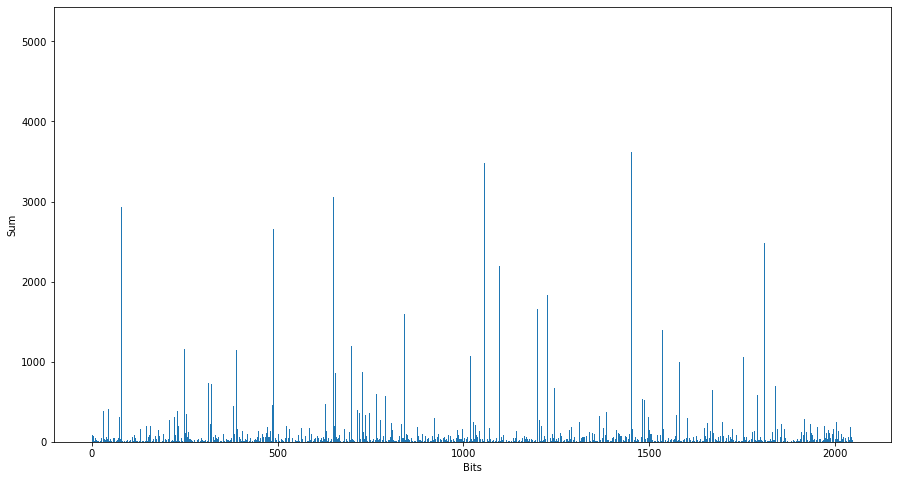

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,8))
sum_bits = morgan_fp.sum(axis=0)
plt.bar(list(range(sum_bits.shape[0])), sum_bits)
plt.xlabel('Bits')
plt.ylabel('Sum')
plt.show()

In [21]:
import numpy as np

labels = np.array(list(df_labels['labels']))

dataset = np.hstack((labels.reshape((-1, 1)), morgan_fp))
dataset

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

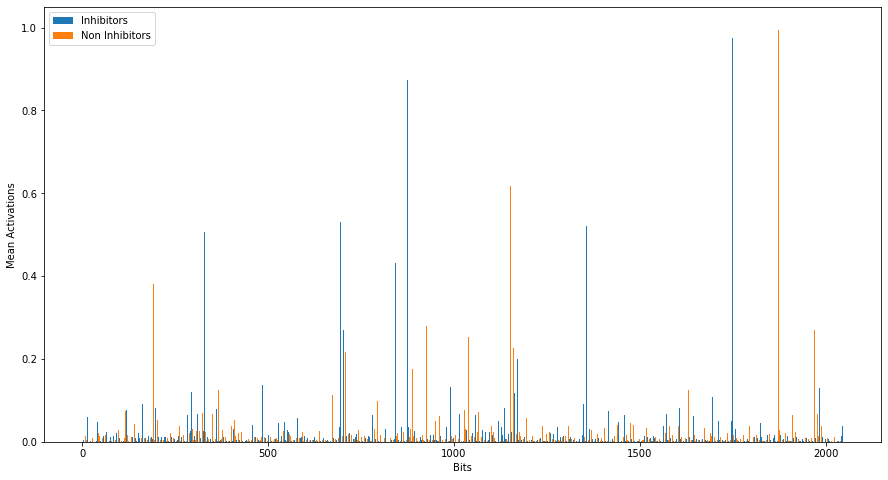

In [47]:
import matplotlib.pyplot as plt


inhibitors_mean_activation = dataset[dataset[:, 0] == 1][:, 1:].mean(axis=0)
non_inhibitors_mean_activation = dataset[dataset[:, 0] == 0][:, 1:].mean(axis=0)


fig, ax = plt.subplots(figsize=(15,8))
n = 2048
x = np.arange(n)
width = 0.4
bar1 = ax.bar(x - width/2, inhibitors_mean_activation, width, label='Inhibitors')
bar2 = ax.bar(x + width/2, non_inhibitors_mean_activation, width, label='Non Inhibitors')

ax.set_xlabel('Bits')
ax.set_ylabel('Mean Activations')
ax.legend()
plt.show()